In [278]:
import itertools
from collections import Counter
import requests
import pandas as pd
import numpy as np
from pymatgen import Element, Composition
import io
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import csv
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

rcparams = {'legend.fontsize': 20,
            'figure.figsize': (12, 8),
            'axes.labelsize': 24,
            'axes.titlesize': 28,
            'xtick.labelsize':20,
            'ytick.labelsize': 20}
mpl.rcParams.update(rcparams)

%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Q1 Exploratory data analysis 

In [279]:
url = 'https://raw.githubusercontent.com/materialsvirtuallab/nano281/master/labs/lab2/data.csv'
resp = requests.get(url)
orig_data = pd.read_csv(io.StringIO(resp.text), na_filter=False)

#df = pd.read_csv('https://raw.githubusercontent.com/materialsvirtuallab/megnet/master/megnet/data/resources/elemental_embedding_1MEGNet_layer.json')
#df.to_csv("embedded_elements.csv", index=None)
df = pd.read_csv("embedded_elements3.csv", index_col=0)
#df.to_csv("embedded_elements3.csv", index=None)


#elem_emb_url = "https://raw.githubusercontent.com/materialsvirtuallab/megnet/master/megnet/data/resources/elemental_embedding_1MEGNet_layer.json"
#resp2 = requests.get(elem_emb_url)
#emb_data = pd.read_csv(io.StringIO(resp2.text), na_filter=False)

In [280]:
orig_data.head()

,task_id,formula,formation_energy_per_atom,e_above_hull,band_gap,has_bandstructure
0,mp-1007923,CrNi3,-0.016354,0.000802,0.0,False
1,mp-1008754,TbHg2,-0.069428,0.329909,0.0,True
2,mp-1016886,MgVO3,-2.241438,0.545977,0.0,True
3,mp-1018902,PrSbPt,-1.111238,0.000000,0.0,True
4,mp-1020595,Rb8PO3,-0.772860,0.491666,0.0,True


In [281]:
#labels = pd.DataFrame(["AtomicRadius", "AtomicVolume", "AtomicWeight", "BulkModulus", "BoilingT","Column" ,"CovalentRadius","Density","ElectronAffinity" , "Electronegativity","FirstIonizationEnergy" , "HeatCapacityMass", "Row", "phi", "SecondIonizationEnergy", "ShearModulus"])
#df.insert (1, "a", labels)
df.head()

,AtomicRadius,AtomicVolume,AtomicWeight,BulkModulus,BoilingT,Column,CovalentRadius,Density,ElectronAffinity,Electronegativity,FirstIonizationEnergy,HeatCapacityMass,Row,phi,SecondIonizationEnergy,ShearModulus
H,0.352363,0.635952,0.217338,-0.191956,0.253751,-0.423261,0.221297,-0.452411,-1.007713,-0.289936,0.126820,-0.025928,0.717508,-0.631993,0.021095,-0.270104
He,-0.067220,0.141113,0.164495,0.136701,0.016505,0.073929,0.151093,-0.138170,-0.180052,-0.130642,0.184020,-0.024526,-0.034060,-0.217201,0.165278,-0.042185
Li,-0.161449,0.179496,-0.114184,0.136510,0.106477,0.047109,0.065104,-0.069099,-0.210581,-0.030035,0.122461,-0.388679,0.137059,-0.357076,0.299678,0.306350
Be,-0.111666,0.760182,0.057829,0.250147,-0.396934,0.128850,0.037942,0.135463,-0.202221,-0.046165,0.166105,0.214563,-0.021428,-0.594812,0.395654,0.000693
B,0.260108,0.707898,0.064846,-0.300478,-0.510219,0.082544,0.589792,0.523288,-0.672266,0.490484,0.496226,0.386530,0.181043,-0.620111,-0.177121,-0.171613


## 1. How many elements are there in this data set?

In [282]:
elements = []
for i in orig_data['formula']:
    elements.append(Composition(i).elements)

orig_data["elements"] = elements
    
unique = set(itertools.chain(*elements))

print("There are %d elements." % len(unique))

There are 89 elements.


## 2. What is the maximum number of elements in a single structure?

In [283]:
nelements = [len(l) for l in elements]
max_els = max(nelements)
print("Maximum number of elements in a structure is %d" % max_els)

Maximum number of elements in a structure is 9


## 3. Plot a histogram of the number of materials having 1, 2, 3, ... `max_els`.

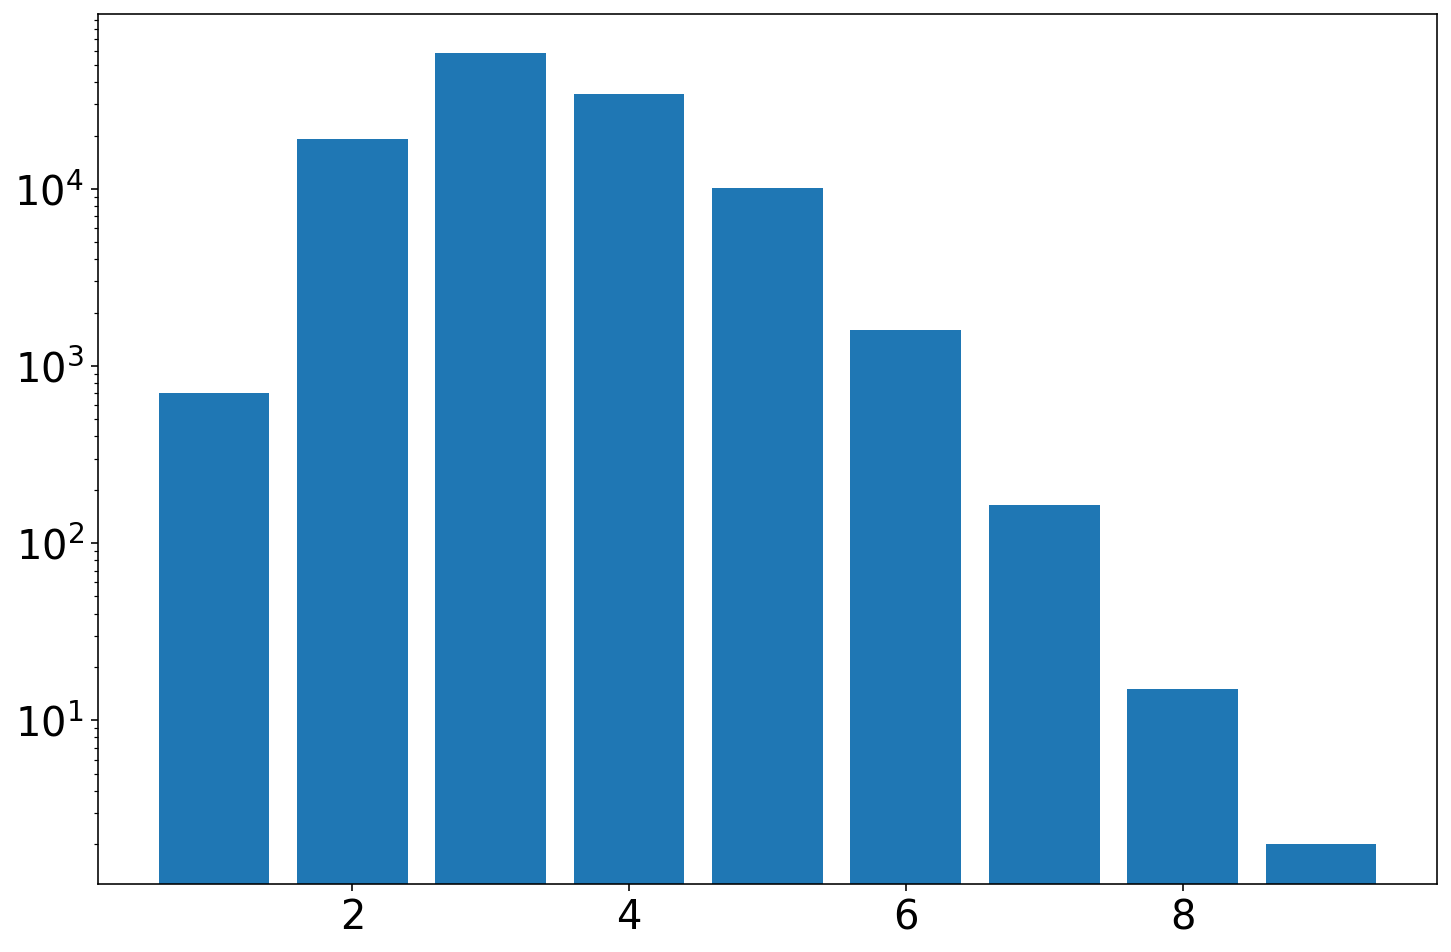

In [284]:
import collections

el_count = collections.Counter(nelements)
fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(range(1, max_els+1), [el_count[i] for i in range(1, max_els+1)])

# Given the very different number of materials in each category, a log scale is better.
plt.yscale('log')

## 4. Count the number of materials where each element is present. Sort this count and answer the following questions. What are the 10 most common elements in this data set? and what are the 10 least common elements in this data set?

In [285]:
el_count = Counter(itertools.chain(*elements))
counts = sorted(el_count.items(), key=lambda k: k[1])
print('Top 10 most common elements are ')
print(counts[-10:][::-1])
print('Top 10 least common elements are ')
print(counts[:10])

Top 10 most common elements are 
[(Element O, 60428), (Element Li, 18580), (Element P, 13321), (Element Mn, 11233), (Element S, 10516), (Element Fe, 10109), (Element N, 9723), (Element F, 9606), (Element Si, 8940), (Element Mg, 8711)]
Top 10 least common elements are 
[(Element Ne, 1), (Element Ar, 2), (Element He, 8), (Element Kr, 15), (Element Xe, 147), (Element Pa, 253), (Element Ac, 297), (Element Np, 340), (Element Pu, 388), (Element Pm, 515)]


# Q2 - Data cleaning and feature computations

## 1. Filter out materials that contain noble gas elements and save it in the variable `data`. How many materials are left? This number is stored in variable n.

In [286]:
elements_temp = [Element.from_Z(i) for i in range(1, 95)]
noble_gases = [i for i in elements_temp if i.is_noble_gas]

def is_contain_noble_gas(elements):
    return any([i in noble_gases for i in elements])

not_contain_noble_gas = [not is_contain_noble_gas(i) for i in orig_data['elements']]

data = orig_data.copy()
data = data[not_contain_noble_gas]
print("The remaining number of materials is %d" % data.shape[0])

The remaining number of materials is 124342


## 2. Load the element property data file element_properties.csv in variable element_data using pandas by setting index_col=0 in pandas.read_csv function. How many NaN are there in each column?

In [287]:
elms_url = 'https://raw.githubusercontent.com/materialsvirtuallab/nano281/master/labs/lab2/element_properties.csv'

resp_elms = requests.get(elms_url)
element_data = pd.read_csv(io.StringIO(resp_elms.text), index_col=0)

#element_data.to_csv("elem_data.csv", index=None)


In [288]:
#emb_vec = np.array(df).reshape(-1, 16)

In [289]:
df.shape

(89, 16)

In [290]:
element_data.head()

,AtomicRadius,AtomicVolume,AtomicWeight,BulkModulus,BoilingT,Column,CovalentRadius,Density,ElectronAffinity,Electronegativity,FirstIonizationEnergy,HeatCapacityMass,Row,phi,SecondIonizationEnergy,ShearModulus
H,0.25,18618.051941,1.007940,NaN,20.13,1.0,31.0,0.0899,72.8,2.20,13.598443,14.304,1.0,5.20,NaN,NaN
He,NaN,37236.035563,4.002602,NaN,4.07,18.0,28.0,0.1785,0.0,NaN,24.587387,5.130,1.0,NaN,54.41776,NaN
Li,1.45,21.544058,6.941000,11.0,1615.00,1.0,128.0,535.0000,59.6,0.98,5.391719,3.582,2.0,2.85,75.64000,4.2
Be,1.05,8.098176,9.012182,130.0,2743.00,2.0,96.0,1848.0000,0.0,1.57,9.322700,1.825,2.0,5.05,18.21114,132.0
B,0.85,7.297767,10.811000,320.0,4273.00,13.0,84.0,2460.0000,26.7,2.04,8.298020,1.026,2.0,5.30,25.15480,NaN


In [291]:
element_data.shape          

(95, 16)

In [292]:
element_data.head()

,AtomicRadius,AtomicVolume,AtomicWeight,BulkModulus,BoilingT,Column,CovalentRadius,Density,ElectronAffinity,Electronegativity,FirstIonizationEnergy,HeatCapacityMass,Row,phi,SecondIonizationEnergy,ShearModulus
H,0.25,18618.051941,1.007940,NaN,20.13,1.0,31.0,0.0899,72.8,2.20,13.598443,14.304,1.0,5.20,NaN,NaN
He,NaN,37236.035563,4.002602,NaN,4.07,18.0,28.0,0.1785,0.0,NaN,24.587387,5.130,1.0,NaN,54.41776,NaN
Li,1.45,21.544058,6.941000,11.0,1615.00,1.0,128.0,535.0000,59.6,0.98,5.391719,3.582,2.0,2.85,75.64000,4.2
Be,1.05,8.098176,9.012182,130.0,2743.00,2.0,96.0,1848.0000,0.0,1.57,9.322700,1.825,2.0,5.05,18.21114,132.0
B,0.85,7.297767,10.811000,320.0,4273.00,13.0,84.0,2460.0000,26.7,2.04,8.298020,1.026,2.0,5.30,25.15480,NaN


In [293]:
print('The numbers of NaN in each column are')
element_data.isna().sum()

The numbers of NaN in each column are


AtomicRadius               7
AtomicVolume               2
AtomicWeight               0
BulkModulus               26
BoilingT                   2
Column                     0
CovalentRadius             0
Density                    2
ElectronAffinity           9
Electronegativity          4
FirstIonizationEnergy      1
HeatCapacityMass          10
Row                        0
phi                       22
SecondIonizationEnergy    12
ShearModulus              34
dtype: int64

In [294]:
df.isna().sum()

AtomicRadius              0
AtomicVolume              0
AtomicWeight              0
BulkModulus               0
BoilingT                  0
Column                    0
CovalentRadius            0
Density                   0
ElectronAffinity          0
Electronegativity         0
FirstIonizationEnergy     0
HeatCapacityMass          0
Row                       0
phi                       0
SecondIonizationEnergy    0
ShearModulus              0
dtype: int64

## 3. Compute the mean values for each column. What are the means for each column? For each column, fill the NaN with the mean value of that column. This is a common data imputation technique.

In [295]:
mean_columns = element_data.mean(skipna=True)

In [297]:
element_data = element_data.fillna(mean_columns)

In [298]:
mean_columns_emb = df.mean(skipna=True)

In [300]:
df = df.fillna(mean_columns_emb)

## 4. Compute the composition-averaged AtomicRadius for all materials and store the results in variable `atomic_radius`. For example, averaged `AtomicRadius` for `Li2O` can be computed as `(2 * 1.45 + 0.6) / 3`, where `1.45` is the `AtomicRadius` for `Li` and `0.6` is the `AtomicRadius` for `O`.

In [301]:
data['composition'] = [Composition(i).to_data_dict['unit_cell_composition']
                           for i in data['formula']]

In [302]:
print(data['composition'])

0                                    {'Cr': 1.0, 'Ni': 3.0}
1                                    {'Tb': 1.0, 'Hg': 2.0}
2                           {'Mg': 1.0, 'V': 1.0, 'O': 3.0}
3                         {'Pr': 1.0, 'Sb': 1.0, 'Pt': 1.0}
4                           {'Rb': 8.0, 'P': 1.0, 'O': 3.0}
                                ...                        
124510                     {'Zn': 1.0, 'Mo': 2.0, 'O': 4.0}
124511                      {'Mg': 1.0, 'V': 2.0, 'O': 4.0}
124512                     {'Ca': 1.0, 'Co': 2.0, 'O': 4.0}
124513    {'Ca': 1.0, 'La': 1.0, 'Cr': 1.0, 'W': 1.0, 'O...
124514    {'Ca': 1.0, 'La': 1.0, 'Cr': 1.0, 'Sn': 1.0, '...
Name: composition, Length: 124342, dtype: object


In [303]:
def composition_to_dict(c):
    if isinstance(c, dict):
        unit_cell_composition = c
    else:
        if isinstance(c, str):
            c = Composition(c)
        unit_cell_composition = c.to_data_dict['unit_cell_composition']
    return unit_cell_composition

def compute_average_from_composition(c, prop):
    unit_cell_composition = composition_to_dict(c)
    res = 0
    total = 0
    for i, j in unit_cell_composition.items():
        
        res += df.loc[i, prop] * j
        total += j
    return res / total

def get_maxmin_properties(c, prop, mode='max'):
    if mode == 'max':
        func = np.max
    elif mode == "min":
        func = np.min
    
    unit_cell_composition = composition_to_dict(c)
    res = func([df.loc[i, prop] for i in unit_cell_composition])
    return res

In [304]:
atomic_radius = [compute_average_from_composition(i, 'AtomicRadius') for i in data['composition']]

## 5. Compute the composition-averaged properties for all properties in element_data and for all materials. Store the results in average_properties. average_properties should have a dimension of (n, 16) where n is the number of materials and 16 is the number of properties.

In [305]:
properties = df.columns
average_properties = []
for prop in properties:
    average_properties.append([compute_average_from_composition(i, prop) for i in data['composition']])

In [306]:
average_properties = np.array(average_properties).T

In [307]:
average_properties.shape

(124342, 16)

## 6. Similar to the previous computations of average properties, compute the maximum properties and minimum properties for all properties and all materials, and store them in variables `max_properties` and `min_properties` respectively. Both variables should have dimension `(n, 16)`.

In [308]:
max_properties = []
min_properties = []
for prop in properties:
    max_properties.append([get_maxmin_properties(i, prop, mode='max') for i in data['composition']])
    min_properties.append([get_maxmin_properties(i, prop, mode='min') for i in data['composition']])

max_properties = np.array(max_properties).T
min_properties = np.array(min_properties).T

In [309]:
max_properties.shape, min_properties.shape

((124342, 16), (124342, 16))

## 7. Concatenate average_properties, max_properties and min_properties, and store the result in variable design_matrix with dimension (n, 48).

In [310]:
design_matrix = np.concatenate([average_properties, 
                                max_properties, min_properties], axis=1)
design_matrix.shape

(124342, 48)

# Q3 - Regression and classification modeling

In [311]:
targets = data[['band_gap', 'formation_energy_per_atom','e_above_hull']]

## 1. Split the data (design_matrix as X, and targets as y) into train and test (ratio 90%:10%), and store them in train_X, train_y for train and test_X and test_y for test. Store the normalized design matrices to norm_train_X, norm_test_X. To make sure the data is reproducible, set the `random_state=42` in `sklearn.model_selection.train_test_split`. 

In [312]:
train_x, test_x, train_y, test_y = train_test_split(design_matrix, targets, test_size=0.1, 
                                                   random_state=42)

## 2. Compute the mean and standard deviation of columns in `train_X`. Both of them should be length 48 vectors. Use them to normalize `train_X` and `test_X`, so that each column has a mean of 0 and standard deviation of 1. Store the normalized design matrices to `norm_train_X`, `norm_test_X`. 

In [313]:
train_x_mean = np.mean(train_x, axis=0)
train_x_std = np.std(train_x, axis=0)
train_x_mean.shape, train_x_std.shape

((48,), (48,))

In [314]:
norm_train_x = (train_x - train_x_mean) / train_x_std
norm_test_x = (test_x - train_x_mean) / train_x_std

## 3. Train a linear model to predict formation_energy_per_atom. What are the mean absolute error (MAE) and root mean squared error (RMSE) on the test data?

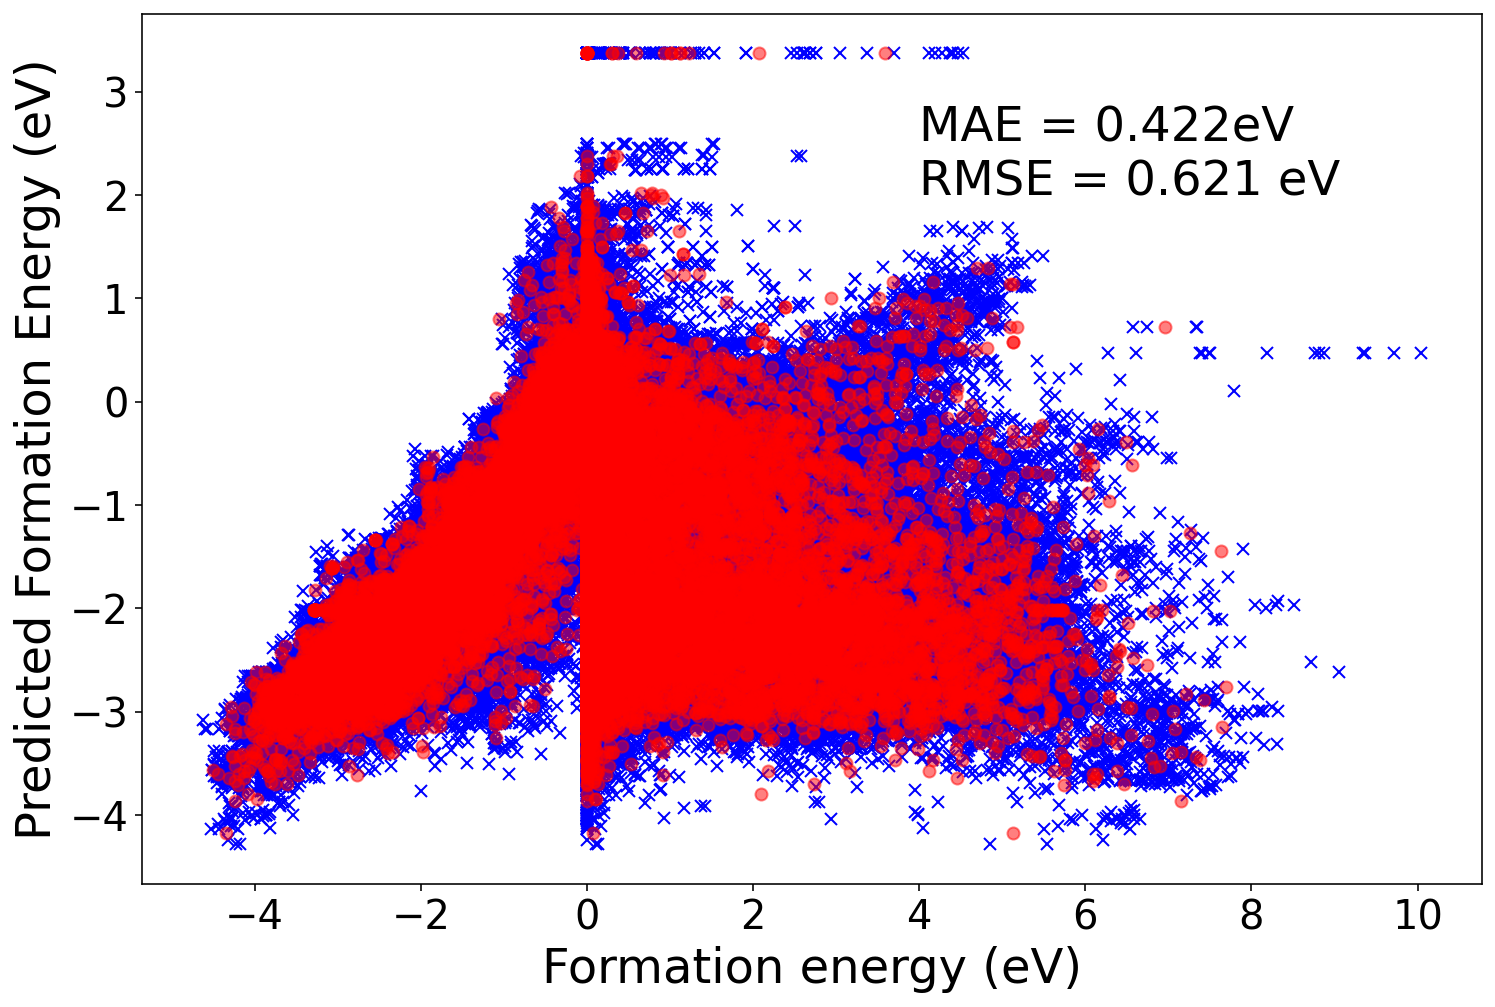

In [315]:
lr = LinearRegression()
lr.fit(norm_train_x, train_y[['formation_energy_per_atom']].values)
pred_test_y = lr.predict(norm_test_x)
pred_train_y = lr.predict(norm_train_x)

mae = mean_absolute_error(pred_test_y, test_y[['formation_energy_per_atom']].values)
rmse = mean_squared_error(pred_test_y, test_y[['formation_energy_per_atom']].values, squared=False)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(train_y, pred_train_y, 'bx')
plt.plot(test_y, pred_test_y, 'ro', alpha=0.5)
plt.xlabel("Formation energy (eV)")
plt.ylabel("Predicted Formation Energy (eV)")
plt.annotate(f"MAE = {mae:.3f}eV\nRMSE = {rmse:.3f} eV", (4, 2), fontsize=24);

## 4. Train a Ridge regression model and a LASSO regression model using alpha=0.1, what are the test MAE and RMSE?

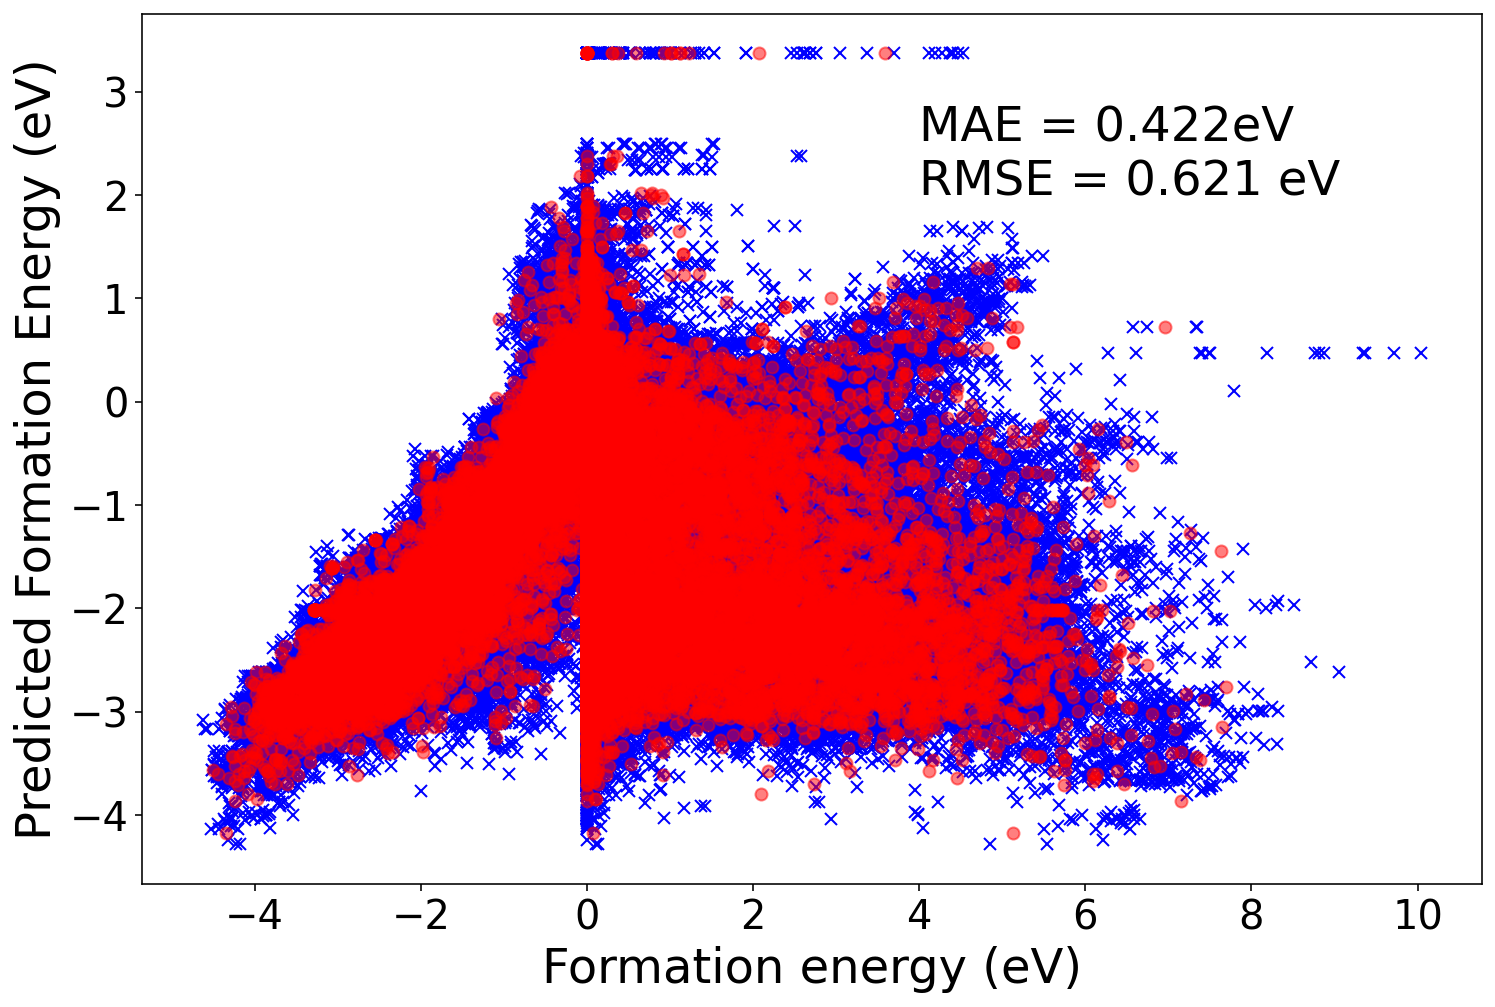

In [316]:
ridge = Ridge(alpha=0.1)
ridge.fit(norm_train_x, train_y[['formation_energy_per_atom']].values)

pred_test_y = lr.predict(norm_test_x)
pred_train_y = lr.predict(norm_train_x)

mae = mean_absolute_error(pred_test_y, test_y[['formation_energy_per_atom']].values)
rmse = mean_squared_error(pred_test_y, test_y[['formation_energy_per_atom']].values, squared=False)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(train_y, pred_train_y, 'bx')
plt.plot(test_y, pred_test_y, 'ro', alpha=0.5)
plt.xlabel("Formation energy (eV)")
plt.ylabel("Predicted Formation Energy (eV)")
plt.annotate(f"MAE = {mae:.3f}eV\nRMSE = {rmse:.3f} eV", (4, 2), fontsize=24);

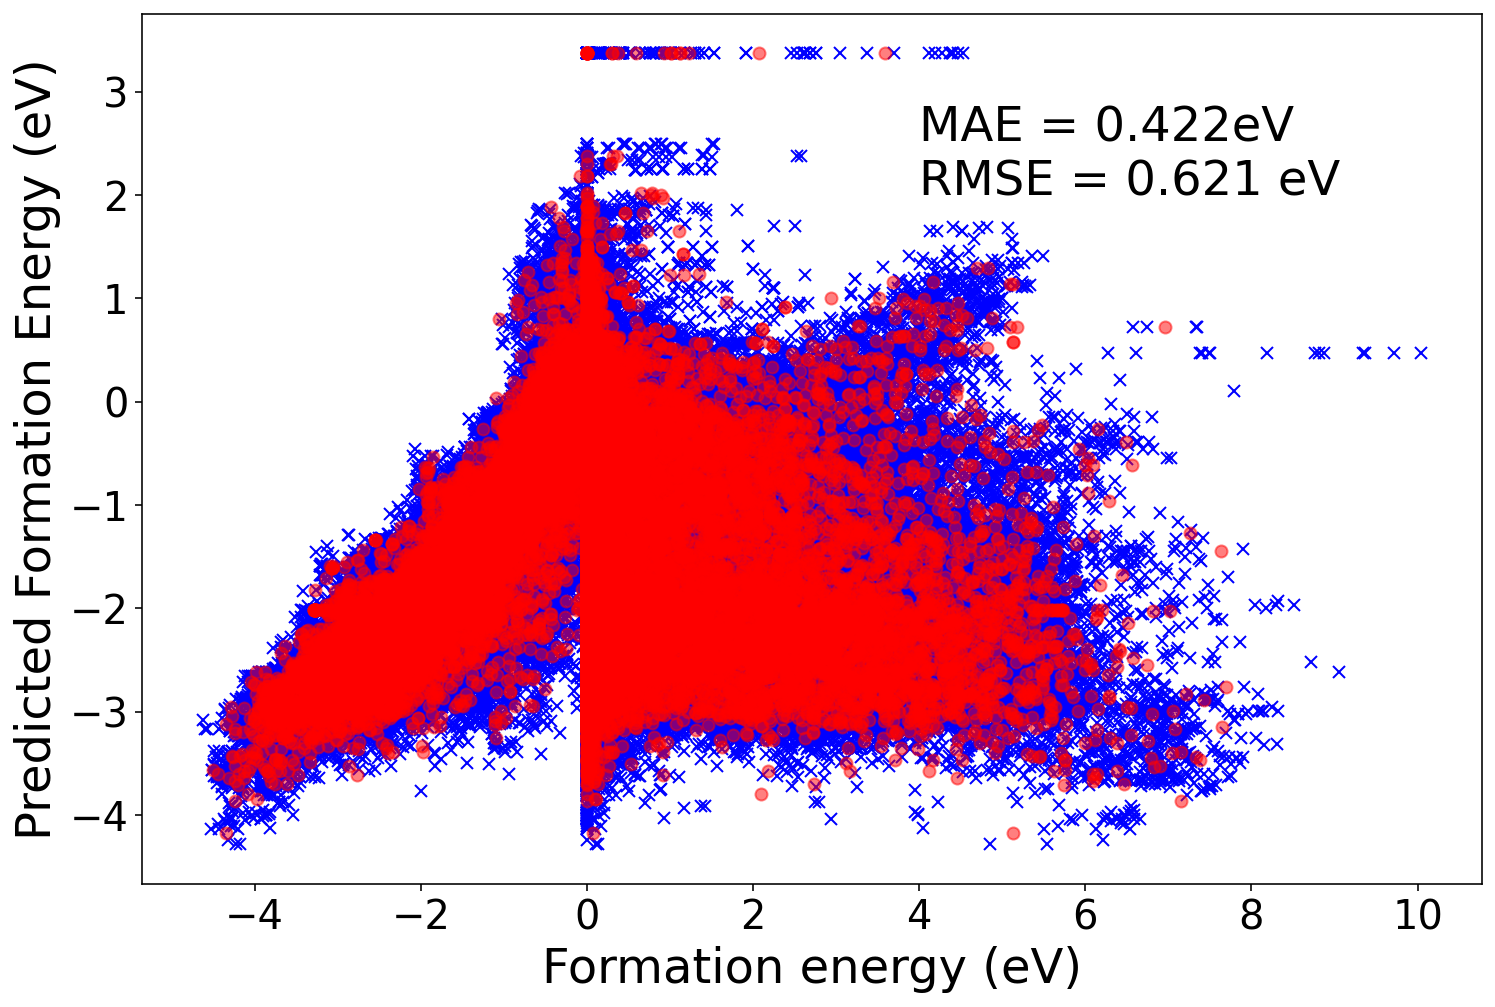

In [317]:
lasso = Lasso(alpha=0.1)
lasso.fit(norm_train_x, train_y[['formation_energy_per_atom']].values)

pred_test_y = lr.predict(norm_test_x)
pred_train_y = lr.predict(norm_train_x)

mae = mean_absolute_error(pred_test_y, test_y[['formation_energy_per_atom']].values)
rmse = mean_squared_error(pred_test_y, test_y[['formation_energy_per_atom']].values, squared=False)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(train_y, pred_train_y, 'bx')
plt.plot(test_y, pred_test_y, 'ro', alpha=0.5)
plt.xlabel("Formation energy (eV)")
plt.ylabel("Predicted Formation Energy (eV)")
plt.annotate(f"MAE = {mae:.3f}eV\nRMSE = {rmse:.3f} eV", (4, 2), fontsize=24);

## 5. Let's define band_gap < 0.001 as metallic and band_gap >= 0.001 as nonmetallic. Construct linear discriminant analysis, quadratic discriminant analysis, and logistic regression models on train data and predict the accuracy of the models on test data.


In [318]:
train_bg_label = train_y['band_gap'] < 0.001
test_bg_label = test_y['band_gap'] < 0.001

In [319]:
lda = LinearDiscriminantAnalysis(solver='svd')
qda = QuadraticDiscriminantAnalysis()
logistic = LogisticRegression(penalty='none', max_iter=1000)

lda.fit(norm_train_x, train_bg_label)
qda.fit(norm_train_x, train_bg_label)
logistic.fit(norm_train_x, train_bg_label)

LogisticRegression(max_iter=1000, penalty='none')

In [320]:
lda_accuracy = lda.score(norm_test_x, test_bg_label)
qda_accuracy = qda.score(norm_test_x, test_bg_label)
lg_accuracy = logistic.score(norm_test_x, test_bg_label)

In [321]:
print('LDA, QDA and logistic regression accuracies are %.3f, %.3f, %.3f, respectively '% (
    lda_accuracy, qda_accuracy, lg_accuracy))

LDA, QDA and logistic regression accuracies are 0.782, 0.773, 0.784, respectively 
